In [880]:
import itertools
import json

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wordcloud

stopwords = set(nltk.corpus.stopwords.words('english'))
stem_func = nltk.PorterStemmer().stem

df = pd.read_csv('C:/Users/matth/Desktop/ADSProject1/data/philosophy_data.csv')
df['tokenized_txt_list'] = df['tokenized_txt'].apply(
    lambda x: [stem_func(word) for word in json.loads(x.replace("'", "\"")) if word not in stopwords])

df['century'] = (df['original_publication_date'] // 100) * 100
df.loc[df['century'] < 1600, 'century'] = -1000000

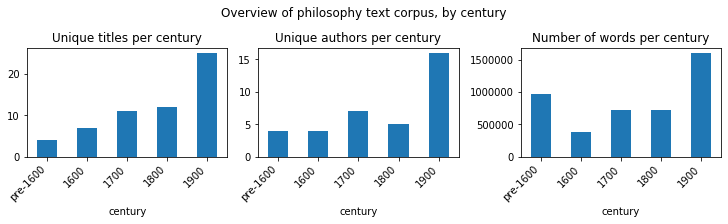

In [881]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(10, 3))
group = 'century'
plt.suptitle(f'Overview of philosophy text corpus, by {group}')

df.groupby(group)['title'].nunique().plot(kind='bar', title=f'Unique titles per {group}', ax=ax[0])
df.groupby(group)['author'].nunique().plot(kind='bar', title=f'Unique authors per {group}', ax=ax[1])

words_by_group = df.groupby(group)['tokenized_txt_list'].apply(lambda x: list(itertools.chain.from_iterable(x)))
words_by_group.apply(len).plot(kind='bar', title=f'Number of words per {group}', ax=ax[2])

for i in range(len(ax)):
    ax[i].set_xticklabels(['pre-1600'] + list(ax[i].get_xticklabels()[1:]), rotation=45, ha='right')

The corpus has data from the centuries 1600, 1700, 1800, and 1900, while the rest is from as far back as 350 BC. It has disproportionately more text from the 1900's.

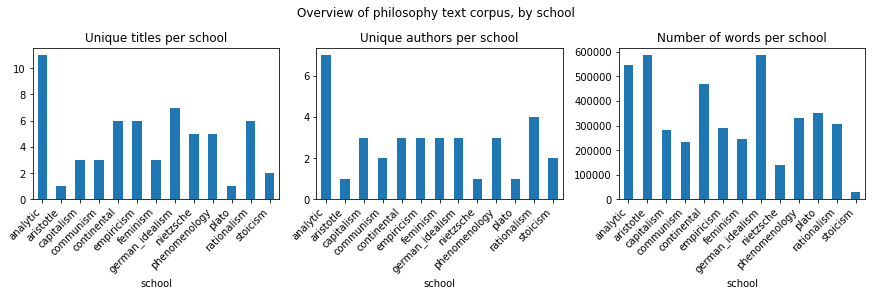

In [882]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(12, 4))
group = 'school'
plt.suptitle(f'Overview of philosophy text corpus, by {group}')

df.groupby(group)['title'].nunique().plot(kind='bar', title=f'Unique titles per {group}', ax=ax[0])
df.groupby(group)['author'].nunique().plot(kind='bar', title=f'Unique authors per {group}', ax=ax[1])

words_by_group = df.groupby(group)['tokenized_txt_list'].apply(lambda x: list(itertools.chain.from_iterable(x)))
words_by_group.apply(len).plot(kind='bar', title=f'Number of words per {group}', ax=ax[2])

for i in range(len(ax)):
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')

The data is well-diversified among different schools of thought.

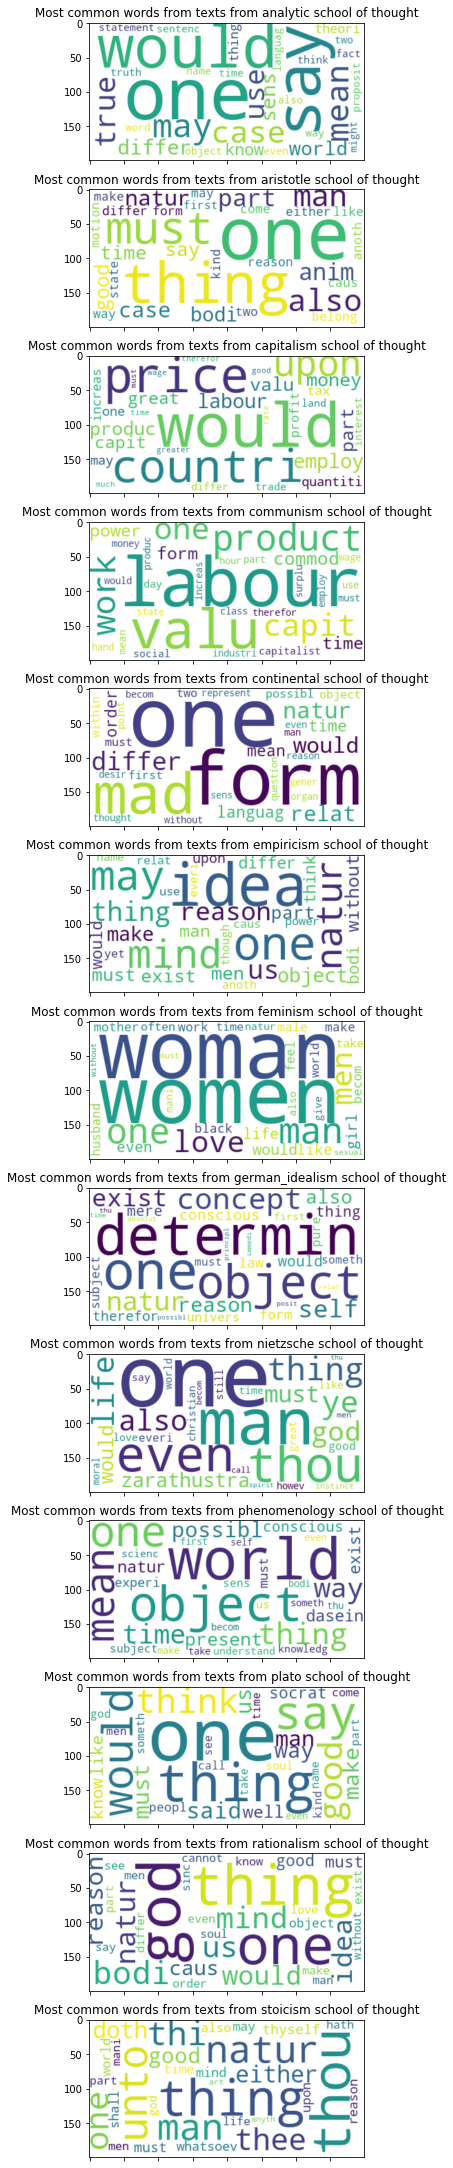

In [883]:
fig, ax = plt.subplots(nrows=words_by_group.shape[0], figsize=(10, 30), constrained_layout=True)

wcs = []
for i, (group_name, words) in enumerate(words_by_group.iteritems()):
    words, counts = np.unique(words, return_counts=True)
    wc = pd.DataFrame({'word': words, 'count': counts})
    wc = wc[~wc['word'].isin(stopwords)].sort_values('count', ascending=False).iloc[:30,]
    cloud = wordcloud.WordCloud(background_color='white').fit_words(wc.set_index('word')['count'].to_dict())
    ax[i].imshow(cloud, interpolation='bilinear')
    ax[i].set_title(f'Most common words from texts from {group_name} school of thought')

for i in range(len(ax)):
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')

An examination of the most common words in the corpus, broken down by school, shows that the texts share certain writing patterns. All schools use the word 'one' very often, to pose theoretical points that apply to individuals. Other common words follow along this line of theoretical phrasing, including words like 'would', 'thing', 'idea', and 'must'. After these words, the word clouds begin to diverge, as each school discusses a different focus of ideas.

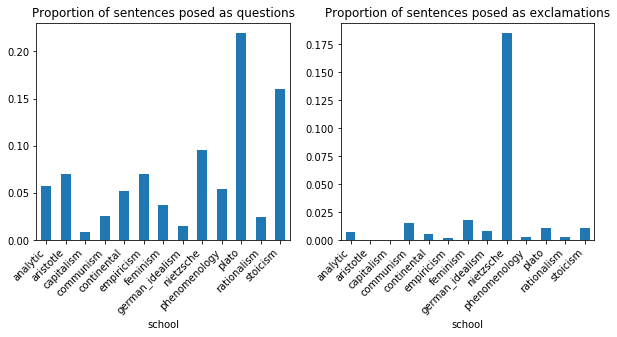

In [884]:
group = 'school'
df['question'] = df['sentence_lowered'].str.contains('\?')
df['exclamation'] = df['sentence_lowered'].str.contains('!')
df['contains_one'] = df['tokenized_txt_list'].apply(lambda words: 'one' in words)

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
for i, marking in enumerate(['question', 'exclamation']):
    q_grouped = df.groupby([group, marking])['sentence_lowered'].count() / df.groupby(group)['sentence_lowered'].count()
    col_to_plot = f'% {marking}'
    q_proportions = q_grouped[q_grouped.index.get_level_values(marking) == True] \
        .reset_index().drop(marking, axis='columns').rename(columns={'sentence_lowered': col_to_plot})
    
    q_proportions.set_index(group)[col_to_plot].plot(
        title=f"Proportion of sentences posed as {marking}s", ax=ax[i], kind='bar')

    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')

The frequency of questions differs considerably across different schools. Plato texs seems to raise questions in his writing the most often. Nietchze texts are the most dramatic and expressive. 

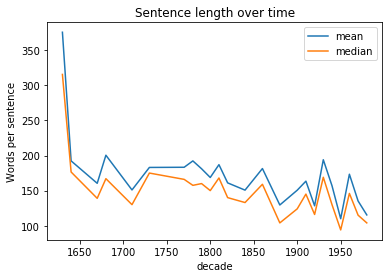

In [885]:
df['decade'] = (df['original_publication_date'] // 10) * 10
decades = df.loc[df['original_publication_date'] >= 1600].groupby('decade')['sentence_length']
decades.agg(['mean', 'median']).plot(
    title='Sentence length over time',
    ylabel='Words per sentence')

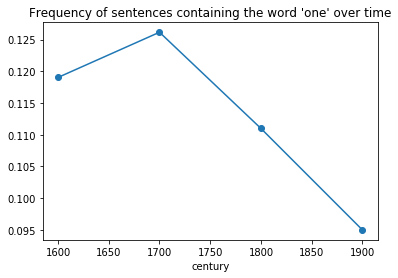

In [886]:
one = df.groupby(['century', 'contains_one']).count()['sentence_lowered'].groupby(level=0).transform(lambda x: x / x.sum())
one[(one.index.get_level_values(1) == True) & (one.index.get_level_values(0) >= 1600)] \
    .droplevel(1).plot(title="Frequency of sentences containing the word 'one' over time", marker='o')

Both sentence length and frequency of the word 'one' has decreased over time, showing a possible style change or shift in conventions as time passed.

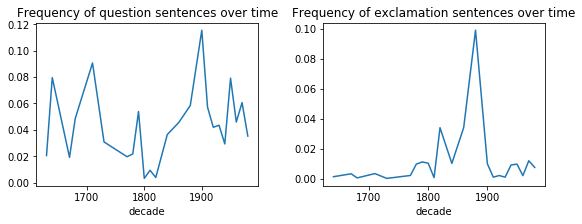

In [887]:
markings = ['question', 'exclamation']
fig, ax = plt.subplots(nrows=1, ncols=len(markings), figsize=(8, 3), constrained_layout=True)
for i, marking in enumerate(markings):
    exclamations = df.groupby(['decade', marking]).count()['sentence_lowered'].groupby(level=0).transform(lambda x: x / x.sum())
    exclamations[(exclamations.index.get_level_values(1) == True) & (exclamations.index.get_level_values(0) >= 1600)] \
        .droplevel(1).plot(ax=ax[i], title=f'Frequency of {marking} sentences over time')

The frequency with which authors use question marks and exclamation points has varied over time, although there has not been a direct trend. This suggests that other than the trend of decreasing sentence length, philosophy writing shows a continuous stylistic evolution.

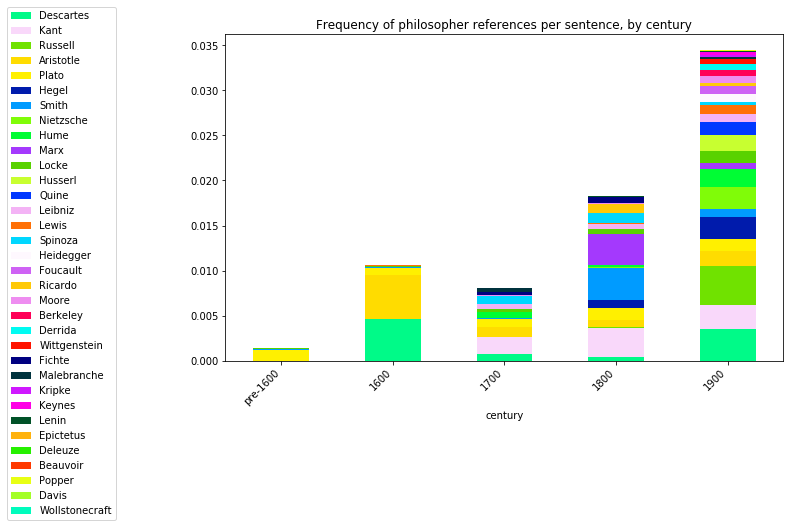

In [888]:
fix, ax = plt.subplots(figsize=(30, 10))

author_stems = {stem_func(author.lower()): author for author in df['author'].unique()}

df['refd_authors'] = df['tokenized_txt_list'].apply(lambda l: list(set(l).intersection(set(author_stems.keys()))))
refd_authors = df.loc[df['refd_authors'].str.len() > 0,
                      ['refd_authors', 'sentence_lowered', 'century', 'question', 'exclamation', 'school']
                     ].explode('refd_authors').rename(columns={'refd_authors': 'refd_author'})
refd_authors['refd_author'] = refd_authors['refd_author'].apply(author_stems.get)
author_freq_order = refd_authors.groupby(['refd_author'])['refd_author'].count().sort_values(ascending=False).index.to_list()
colors = [plt.get_cmap('gist_ncar')(x) for x in np.linspace(0, 1, len(author_freq_order))]
random.shuffle(colors)
refd_authors_freq = refd_authors.groupby(['century', 'refd_author']).count()['sentence_lowered'] / df.groupby('century')['sentence_lowered'].count()
refd_authors_freq.rename('referenced_authors').unstack()[author_freq_order].plot(
    kind='bar', stacked=True, figsize=(10, 6), title='Frequency of philosopher references per sentence, by century', color=colors, ax=ax)
ax.set_xticklabels(['pre-1600'] + list(ax.get_xticklabels()[1:]), rotation=45, ha='right')
ax.legend(bbox_to_anchor=(-.4, 1.1), loc='upper left', ncol=1)

The proportion of sentences that mention another philosopher has increased over time. Descartes, Kant, Aristotle, and Plato seem to have had consistent influence over these writings across multiple centuries. Plato's incredible tendency to question illuminates a reason why he had so much influence on future philosophers.

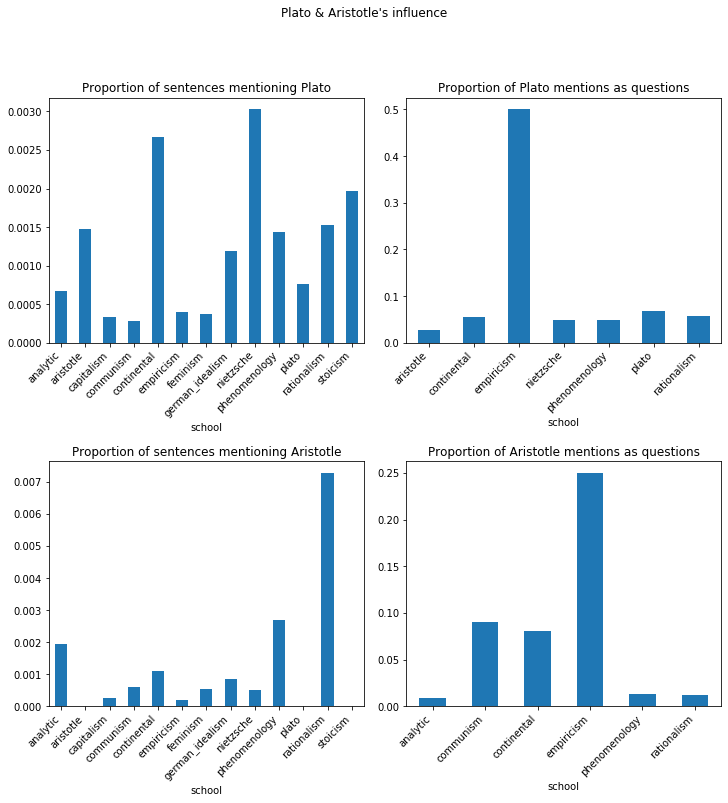

In [889]:
group = 'school'

significant_authors = ['Plato', 'Aristotle']
fig, ax = plt.subplots(ncols=len(significant_authors), nrows=2, figsize=(10, 10), constrained_layout=True)
plt.suptitle("Plato & Aristotle's influence", y=1.1)
for i, author in enumerate(significant_authors):
    (refd_authors.loc[refd_authors['refd_author'] == author].groupby(group).count()['refd_author'] / df.groupby(group)['sentence_lowered'].count()) \
        .plot(kind='bar', ax=ax[i, 0], title=f'Proportion of sentences mentioning {author}')
    
    plato_questions = refd_authors.loc[refd_authors['refd_author'] == author].groupby([group, 'question']).count()
    plato_by_century = plato_questions['sentence_lowered'].groupby(level=0).transform(lambda x: x / x.sum())
    plato_by_century[plato_by_century.index.get_level_values(1)].droplevel(1).plot(
        kind='bar', title=f'Proportion of {author} mentions as questions', ax=ax[i, 1])
    
    ax[i, 0].set_xticklabels(ax[i, 0].get_xticklabels(), rotation=45, ha='right')
    ax[i, 1].set_xticklabels(ax[i, 1].get_xticklabels(), rotation=45, ha='right')

Greek philosophy has had a profound effect on the texts in this corpus. The continental and nietzche schools have referenced Plato the most, whereas rationalism has referenced Aristotle far and away the most. Writers from the empiricism school seem especially to raise questions on Greek philosophy. Plato and Aristotle have clearly made their marks on a huge range of thought.